# Imports

Generating pipe tiles in a grid using constraint optimization

In [215]:
from qiskit import QuantumCircuit
# from qiskit_utils import algorithm_globals
from qiskit_algorithms.minimum_eigensolvers import QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import *
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
from qiskit_optimization import *
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.visualization import plot_histogram
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Creating a graph

We will put numbers in a 2D matrix to represent a grid-like graph. Each cell in the matrix represents a vertex of the graph.

In [216]:
#Dims
rows = 3
cols = 3

#construct a matrix representation of vertices/tiles, matrix[row][col]
G = nx.Graph()
tile_matrix = np.zeros(shape=(rows,cols), dtype=int) #tile (row,col) -> tile id
tile_mappings = dict() #tile id -> tile (row,col)
tile_count = 0
for r in range(rows):
    for c in range(cols):
        tile_matrix[r,c] = tile_count
        tile_mappings[tile_count] = (r,c)
        G.add_node(tile_count)
        tile_count += 1

print(tile_matrix)

[[0 1 2]
 [3 4 5]
 [6 7 8]]


# Adding edges to the graph 

 We can also use the matrix to determine what tiles are neighbors and in what direction and create edges to a tiles up down left and right neighbors.

 We can use these edges to represent pipes, as shown in the output graph image of this block of code

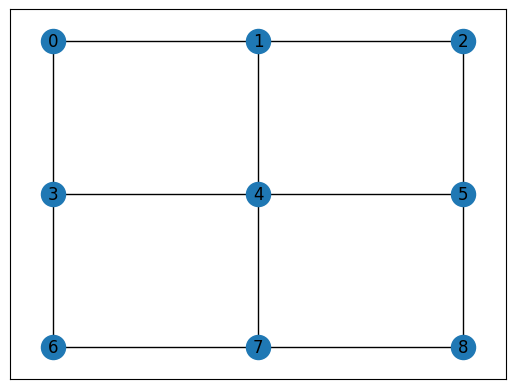

In [217]:
def make_edge(u,v):
    return "e(%d,%d)" % (min(u,v), max(u,v))

#primitive: tuple (number, dir) i.e. 0d is for the downward edge on 0
#full edge: e(u,v) where u < v
#half edge: h(u,dir)
edge_mappings = dict()
#establish edges by trying to go up down left right in the matrix.
for r in range(rows):
    for c in range(cols):
        this_tile = tile_matrix[r,c] #id of tile at row r and column c
        #down edge (r+1)
        if (rows==1): #cannot use edges, t is for tile, and vertical and horizontal tiles can be present in the same location (to form cross)
            edge_mappings["t(%d,%s)" % (tile_matrix[r,c],'v')] = [(tile_matrix[r,c], 'd'),(tile_matrix[r,c], 'u')]
        elif (r+1 < rows):
            e_down = make_edge(this_tile, tile_matrix[r+1,c])
            edge_mappings[e_down] = [(this_tile, 'd'), (tile_matrix[r+1,c], 'u')]
            G.add_edge(this_tile, tile_matrix[r+1,c])
            if (r == 0):
                edge_mappings[e_down].append((this_tile,'u'))
            if (r+1 == rows-1):
                edge_mappings[e_down].append((tile_matrix[r+1,c],'d'))

        #right edge (c+1)
        if (cols==1):
            edge_mappings["t(%d,%s)" % (tile_matrix[r,c],'h')] = [(tile_matrix[r,c], 'r'),(tile_matrix[r,c], 'l')]
        elif (c+1 < cols): 
            e_right = make_edge(this_tile, tile_matrix[r,c+1])
            edge_mappings[e_right] = [(this_tile, 'r'), (tile_matrix[r,c+1], 'l')]
            G.add_edge(this_tile, tile_matrix[r,c+1])
            if (c == 0):
                edge_mappings[e_right].append((this_tile,'l'))
            if (c+1 == cols-1):
                edge_mappings[e_right].append((tile_matrix[r,c+1],'r'))
#mapping primitive i.e. (0,'d') to an edge i.e. (0,2)
h_mappings = dict()

for key in edge_mappings:
    for prim in edge_mappings[key]:
        h_mappings[prim] = key

nodepos={}
for key in tile_mappings:
    tilepos = tile_mappings[key]
    nodepos[key] = (tilepos[1], -tilepos[0])
pos = nx.spring_layout(G,pos=nodepos, fixed=nodepos.keys())
nx.draw_networkx(G,pos)

# Setting up constraints for the edges

The only requirement is that pipes are not cut off. Since we are only accounting for 4 tile types (none, horizontal, vertical, cross), this means that if a tile X has a tile to the right that is a horizontal pipe, then X must be either a cross or a horizontal pipe.

This means we can treat each edge as a binary variable: 1 means a pipe in the edge's orientation is present in the two tiles this edge connects, and 0 means there is no pipe. Although a cross-junction type tile is not strictly encoded, it can still be generated if a tile's vertical edges and horizontal edges are both marked as 1.

To ensure that pipes do not get cut off, we can force "opposing" edges of a vertex/tile to exist or not exist at the same time. So that pair of edges must both be 1 or 0 together.

In [218]:
# Create a QUBO
qubo = QuadraticProgram()

#linear combination coefficient:
coefs = {}
for edge in edge_mappings:
    qubo.binary_var(edge)
    if edge[0] == "t":
        coefs[edge] = 0
    else:
        coefs[edge] = None

for r in range(rows):
    for c in range(cols):
        this_tile = tile_matrix[r,c]
        edge_u = h_mappings[(this_tile, 'u')]
        edge_d = h_mappings[(this_tile, 'd')]
        edge_l = h_mappings[(this_tile, 'l')]
        edge_r = h_mappings[(this_tile, 'r')]
        if edge_u != edge_d:
            qubo.linear_constraint(linear={edge_u:1, edge_d:-1}, sense="==", rhs=0)
            coefs[edge_u] = 1
            coefs[edge_d] = 1
        elif coefs[edge_u] == None:
            coefs[edge_u] = 0
        if edge_r != edge_l:
            qubo.linear_constraint(linear={edge_r:1, edge_l:-1}, sense="==", rhs=0)
            coefs[edge_r] = 1
            coefs[edge_l] = 1
        elif coefs[edge_r] == None:
            coefs[edge_r] = 0

# Adding additional constraints

Force tile(s) to have a specific pipe layout. (n - nothing, v - vertical, h - horizontal, x - junction)

In [219]:
# example:
# tile_constraints = {(0,0): "h", (2,2): "v"}
tile_constraints = {}

def constrainHorizontal(tile_num, should_exist):
    edge_r = h_mappings[(tile_num, 'r')]
    qubo.linear_constraint(linear={edge_r:1}, sense="==", rhs=(1 if should_exist else 0))

def constrainVertical(tile_num, should_exist):
    edge_d = h_mappings[(tile_num, 'd')]
    qubo.linear_constraint(linear={edge_d:1}, sense="==", rhs=(1 if should_exist else 0))

for t in tile_constraints:
    r, c = t
    tile_num = tile_matrix[r,c]
    tile_type = tile_constraints[t]
    if tile_type == "n":
        constrainHorizontal(tile_num, False)
        constrainVertical(tile_num, False)
    elif tile_type == "v":
        constrainHorizontal(tile_num, False)
        constrainVertical(tile_num, True)
    elif tile_type == "h":
        constrainHorizontal(tile_num, True)
        constrainVertical(tile_num, False)
    elif tile_type == "x":
        constrainHorizontal(tile_num, True)
        constrainVertical(tile_num, True)

qubo.minimize(linear = coefs, quadratic={})

print(qubo.prettyprint())

Problem name: 

Minimize
  e(0,1) + e(0,3) + e(1,2) + e(1,4) + e(2,5) + e(3,4) + e(3,6) + e(4,5) + e(4,7)
  + e(5,8) + e(6,7) + e(7,8)

Subject to
  Linear constraints (6)
    -e(0,1) + e(1,2) == 0  'c0'
    e(0,3) - e(3,6) == 0  'c1'
    e(1,4) - e(4,7) == 0  'c2'
    -e(3,4) + e(4,5) == 0  'c3'
    e(2,5) - e(5,8) == 0  'c4'
    -e(6,7) + e(7,8) == 0  'c5'

  Binary variables (12)
    e(0,3) e(0,1) e(1,4) e(1,2) e(2,5) e(3,6) e(3,4) e(4,7) e(4,5) e(5,8) e(6,7)
    e(7,8)



# Conversion quantum circuit

In [220]:
converter = QuadraticProgramToQubo()
qubo_with_penalty = converter.convert(qubo)
op, offset = qubo_with_penalty.to_ising()
print("offset: {}".format(offset))
print("operator:")
print(op)

offset: 45.0
operator:
SparsePauliOp(['IIIIIIIIIIIZ', 'IIIIIIIIIIZI', 'IIIIIIIIIZII', 'IIIIIIIIZIII', 'IIIIIIIZIIII', 'IIIIIIZIIIII', 'IIIIIZIIIIII', 'IIIIZIIIIIII', 'IIIZIIIIIIII', 'IIZIIIIIIIII', 'IZIIIIIIIIII', 'ZIIIIIIIIIII', 'IIIIIIIIZIZI', 'IIIIIIZIIIIZ', 'IIIIZIIIIZII', 'IIIZIZIIIIII', 'IIZIIIIZIIII', 'ZZIIIIIIIIII'],
              coeffs=[-0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,
 -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -6.5+0.j, -6.5+0.j,
 -6.5+0.j, -6.5+0.j, -6.5+0.j, -6.5+0.j])


# Circuit Execution

In [221]:
qaoa_mes = QAOA(sampler=Sampler(options={"shots":100000}), optimizer=COBYLA())
qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA
qaoa_result = qaoa.solve(qubo)
print(qaoa_result.prettyprint())

objective function value: 0.0
variable values: e(0,3)=0.0, e(0,1)=0.0, e(1,4)=0.0, e(1,2)=0.0, e(2,5)=0.0, e(3,6)=0.0, e(3,4)=0.0, e(4,7)=0.0, e(4,5)=0.0, e(5,8)=0.0, e(6,7)=0.0, e(7,8)=0.0
status: SUCCESS


# Getting Solution
Save results that fit the constraints

In [222]:
def get_filtered_samples(
    samples: List[SolutionSample],
    threshold: float = 0,
    allowed_status: Tuple[OptimizationResultStatus] = (OptimizationResultStatus.SUCCESS,),
):
    res = []
    for s in samples:
        if s.status in allowed_status and s.probability > threshold:
            res.append(s)

    return res
filtered_samples = get_filtered_samples(
    qaoa_result.samples, threshold=0.001, allowed_status=(OptimizationResultStatus.SUCCESS,)
)

total_prob = 0
for s in filtered_samples:
    total_prob += s.probability

print(total_prob)

0.87436


# Displaying Solution

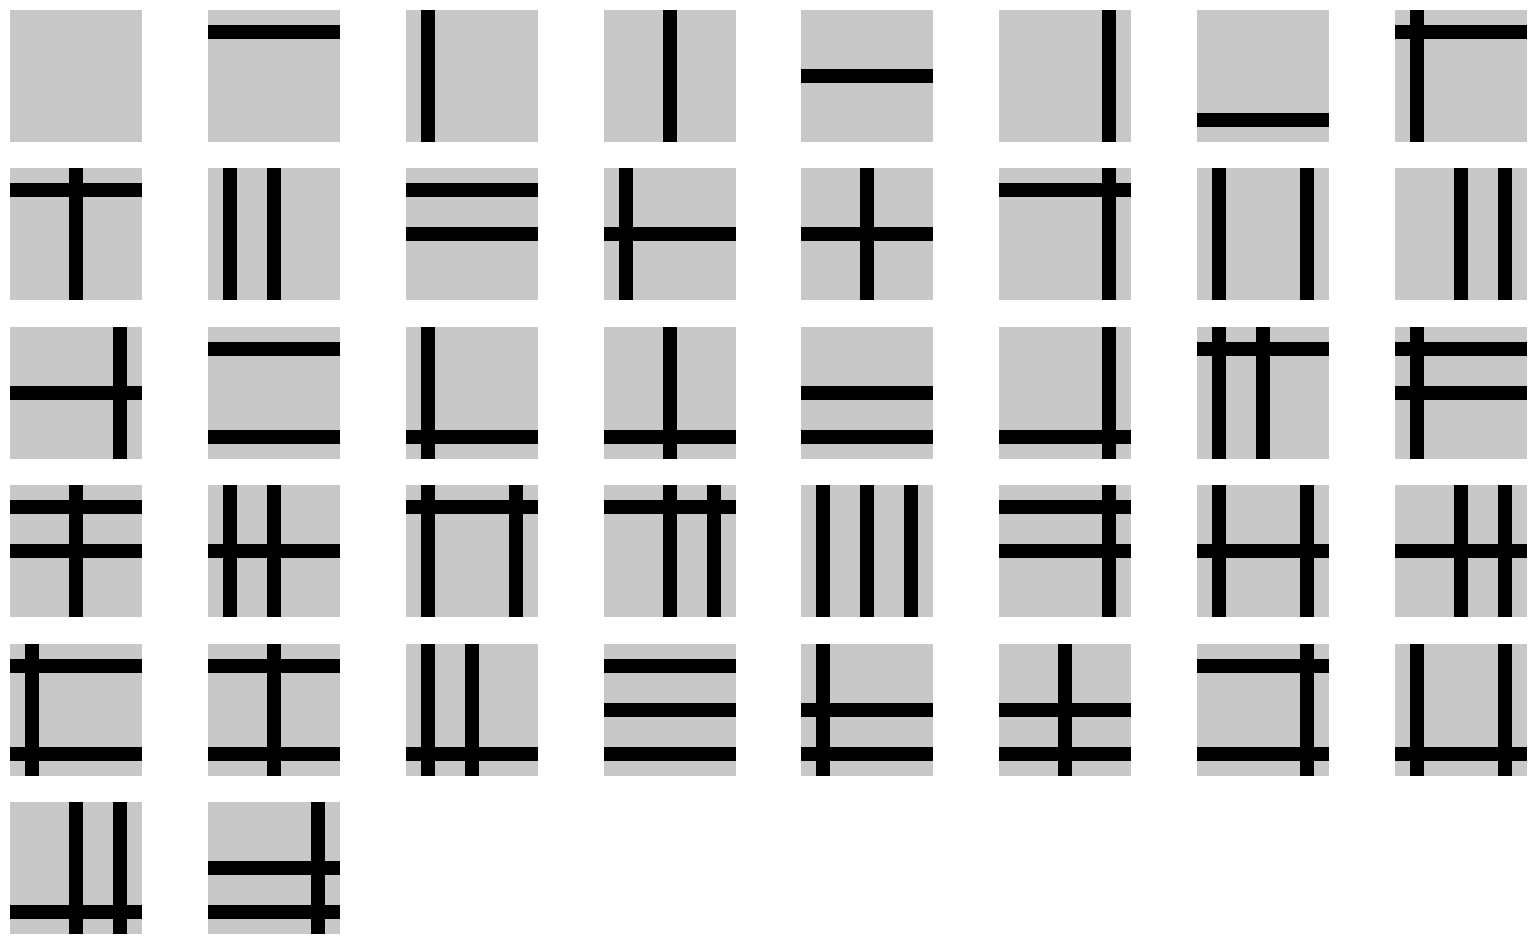

In [223]:
height, width, channel = 3 * rows, 3 * cols, 3

figcols = 25 // cols
figrows = len(filtered_samples) // figcols + 1
fig = plt.figure(figsize=(20, figrows * 2)) 


def paint(tile_mappings, h):
    tile, dir = h
    r, c = tile_mappings[tile]
    center = (r * 3 + 1, c * 3 + 1) #center of the (r,c) tile on the canvas
    dir_modifier = None
    if dir == 'u':
        dir_modifier = (-1,0)
    if dir == 'd':
        dir_modifier = (1,0)
    if dir == 'l':
        dir_modifier = (0,-1)
    if dir == 'r':
        dir_modifier = (0,1)
    draw_tile_dir = (center[0] + dir_modifier[0], center[1] + dir_modifier[1])
    return [center, draw_tile_dir]

for s in range(len(filtered_samples)):
    arr = np.full((height, width, channel), [200, 200, 200], dtype=('uint8'))
    draw_target = filtered_samples[s]
    for i, v in enumerate(draw_target.x):
        if int(v) == 1:
            e = qaoa_result.variables[i].name
            prims = edge_mappings[e]
            for p in prims:
                paint_tiles = paint(tile_mappings, p)
                for t in paint_tiles:
                    for chan in range(3):
                        arr[t[0], t[1], chan] = 0
    fig.add_subplot(figrows, figcols, s + 1)
    plt.imshow(arr)
    plt.axis('off')

Sample with probability 0.2897
Variables with value 1:
Sample with probability 0.05712
Variables with value 1:
e(0,1)
e(1,2)
Sample with probability 0.05968
Variables with value 1:
e(0,3)
e(3,6)
Sample with probability 0.05874
Variables with value 1:
e(1,4)
e(4,7)
Sample with probability 0.0593
Variables with value 1:
e(3,4)
e(4,5)
Sample with probability 0.05846
Variables with value 1:
e(2,5)
e(5,8)
Sample with probability 0.06064
Variables with value 1:
e(6,7)
e(7,8)
Sample with probability 0.0118
Variables with value 1:
e(0,3)
e(0,1)
e(1,2)
e(3,6)
Sample with probability 0.01254
Variables with value 1:
e(0,1)
e(1,4)
e(1,2)
e(4,7)
Sample with probability 0.01192
Variables with value 1:
e(0,3)
e(1,4)
e(3,6)
e(4,7)
Sample with probability 0.0122
Variables with value 1:
e(0,1)
e(1,2)
e(3,4)
e(4,5)
Sample with probability 0.01213
Variables with value 1:
e(0,3)
e(3,6)
e(3,4)
e(4,5)
Sample with probability 0.01221
Variables with value 1:
e(1,4)
e(3,4)
e(4,7)
e(4,5)
Sample with probability 

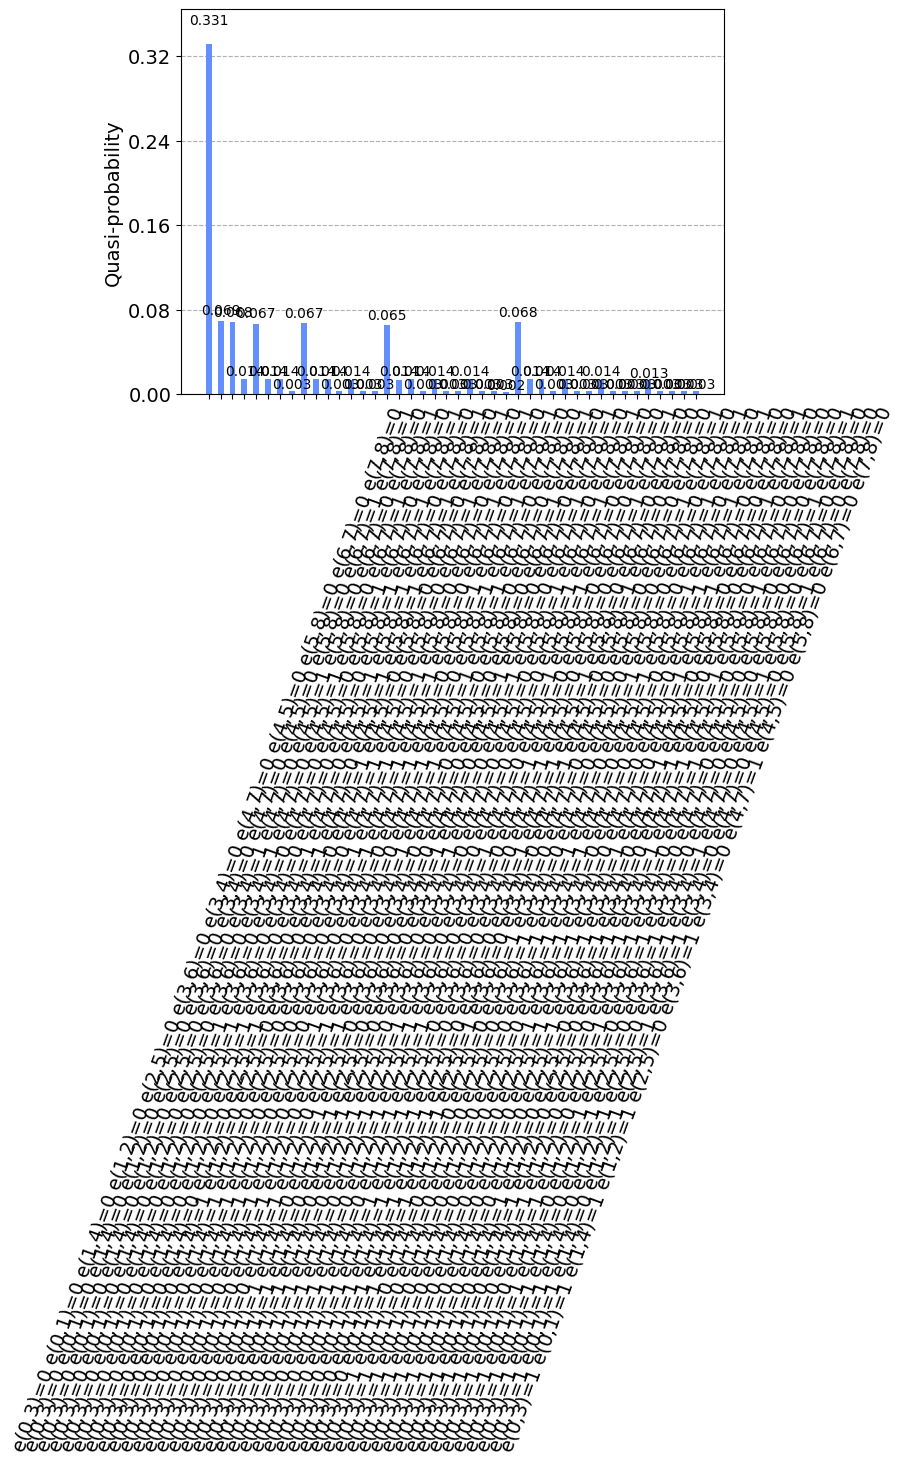

In [224]:
samples_for_plot = {}

for s in filtered_samples:
    sample_str = " ".join(f"{qaoa_result.variables[i].name}={int(v)}" for i, v in enumerate(s.x))

    samples_for_plot[sample_str] = s.probability

    print("Sample with probability", s.probability)
    print("Variables with value 1:")
    for i, v in enumerate(s.x):
        if int(v) == 1:
            print(qaoa_result.variables[i].name)

plot_histogram(samples_for_plot)
